## Training a CNN on synthetic data with vanilla pytorch (no fastai functionality)

- defining a new model from scratch
- creating a dataloader
- define loss function and optimizer
- create the trainingloop

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../src/')
import luke_data

In [31]:
def normalize(data, m, s):
    return (data-m)/s
    
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [35]:
# import pickle #seriealizing and deserializing data in python
# import bz2 #for zipping data, we do this because we keep the data in a git repository for simplicity
# traindata = pickle.load(bz2.BZ2File('../data/train.pickle.bz2','r'))
x_train,y_train,x_valid,y_valid = luke_data.get_data()
x_train,x_valid = normalize_to(x_train,x_valid)

For educational purposes we would like to train a CNN based classifier to distinguish 4 different classes. Images (128x128) showing four dots and a pyramid that can point in any of the four directions (up,down,left,right). The positions of these elements are purely random. In total we have a dataset of 3200 images

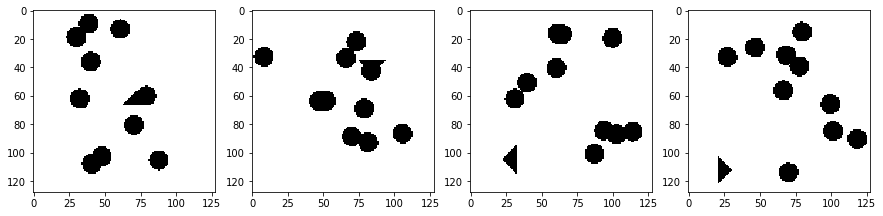

In [190]:
plt.figure(figsize=(15,5))
for i,ii in enumerate([0,4,2,8]):
    plt.subplot(1,4,i+1)
    plt.imshow(x_train[ii][0], cmap='gray')

In [171]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

Defining a model in Pytorch:

In [172]:
class LukeConvBlock(nn.Module):
    def __init__(self, insize, outsize, batchnorm=True, cn_dropout=0):
        super().__init__()
        self.insize = insize
        self.outsize = outsize
        self.batchnorm = batchnorm
        block  = []
        block.append(nn.Conv2d(insize, outsize, kernel_size=3, padding=1))
        block.append(nn.ReLU(inplace=True))
        if batchnorm:
            block.append(nn.BatchNorm2d(outsize))
        if cn_dropout>0:
            block.append(nn.Dropout2d(cn_dropout))
        block.append(nn.Conv2d(outsize, outsize, kernel_size=3, padding=1))
        block.append(nn.ReLU(inplace=True))
        if batchnorm:
            block.append(nn.BatchNorm2d(outsize))
        if cn_dropout>0:
            block.append(nn.Dropout2d(cn_dropout))
        block.append(nn.MaxPool2d(2))
        self.block = nn.Sequential(*block)
        
    def forward(self, x):
        return self.block(x)
        
                     
class Luke(nn.Module):    
    def __init__(self, fl_features=16, channels=1, depth=3, batchnorm=True, cn_dropout=0):
        super().__init__()
        
        cnn_seq = []
        cnn_seq.append(LukeConvBlock(channels,fl_features,batchnorm,cn_dropout=cn_dropout))
        for i in range(depth-1):
            cnn_seq.append(LukeConvBlock(fl_features*2**(i),fl_features*2**(i+1),batchnorm,cn_dropout=cn_dropout))

        cnn_seq[-1].block[-1] = nn.AdaptiveAvgPool2d(output_size=(7, 7))
        self.cnn_seq = nn.Sequential(*cnn_seq)
        self.nfeat_afterconv = 7*7*fl_features*2**(i+1)
        classifier = []
        classifier.append(nn.Linear(self.nfeat_afterconv,2000))
        classifier.append(nn.ReLU(inplace=True))
        if batchnorm:
            classifier.append(nn.BatchNorm1d(2000))
        classifier.append(nn.Linear(2000,1000))
        classifier.append(nn.ReLU(inplace=True))
        if batchnorm:
            classifier.append(nn.BatchNorm1d(1000))
        classifier.append(nn.Linear(1000,4))
        self.classifier = nn.Sequential(*classifier)
        
    def forward(self, x):
        x = self.cnn_seq(x)
        x = x.view(-1,self.nfeat_afterconv)
        return self.classifier(x)

In [192]:
Luke()

Luke(
  (cnn_seq): Sequential(
    (0): LukeConvBlock(
      (block): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU(inplace=True)
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): LukeConvBlock(
      (block): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU(inplace=True)
        (5): BatchNorm2d(32, eps=1e-05, mom

In pytorch we need to provide a Dataset object from which a dataloader can draw data (calling the getitem function)

In [173]:
class Dataset2d(Dataset):
    def __init__(self, ds):
        self.ds = ds

    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        # online data augmentation would go here
        return self.ds[idx]

In [174]:
import random
import math
random.shuffle(traindata)

# splitting the data into training and validation
validation_data = traindata[0:math.floor(len(traindata)*0.1)]
traindata = traindata[math.floor(len(traindata)*0.1):]

# creating the dataset objects
train_ds = Dataset2d(list(zip(x_train, y_train)))
vali_ds = Dataset2d(list(zip(x_valid, y_valid)))

# creating the train loader
trainloader = DataLoader(train_ds, batch_size=20, shuffle=True, num_workers=4, pin_memory=True)
validationloader = DataLoader(vali_ds, batch_size=20, shuffle=False, num_workers=4, pin_memory=True)

now we create the model, define the optmizer and the loss function

In [215]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Luke(batchnorm=True, cn_dropout=0.05).to(device)
epochs = 30
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [216]:
# model

minimum training loop

In [217]:
# for epoch in range(epochs):
#     for data in trainloader:
#         inputs, labels = data
#         inputs = inputs.to(device) 
#         labels = labels.to(device)
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         print('\r Epoch: %d, Loss: %.3f' % (epoch+1, loss.item()), end = '')

In [218]:
from livelossplot import PlotLosses

Beyond a minimum training loop we would like to get metrics about the validation set and would like to observ the training progress. livelossplot is a minimalistic (compared to tensorboard) library to achieve this. 

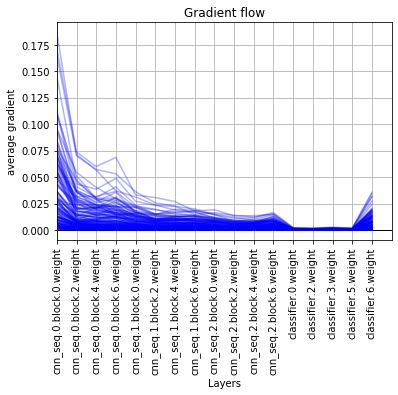

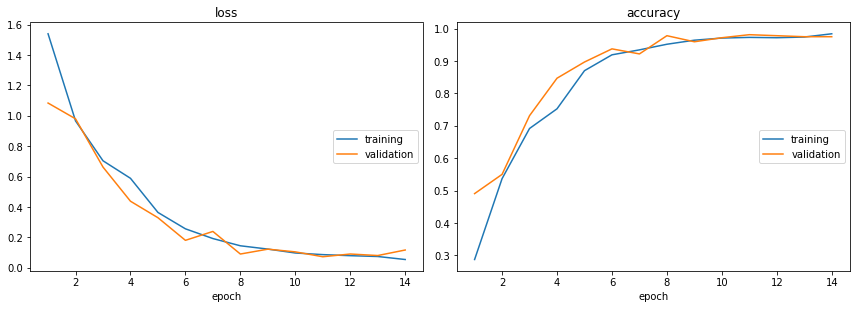

loss:
training   (min:    0.053, max:    1.540, cur:    0.053)
validation (min:    0.072, max:    1.084, cur:    0.116)

accuracy:
training   (min:    0.287, max:    0.984, cur:    0.984)
validation (min:    0.491, max:    0.981, cur:    0.975)
[15,   144] Train_loss: 0.046

KeyboardInterrupt: 

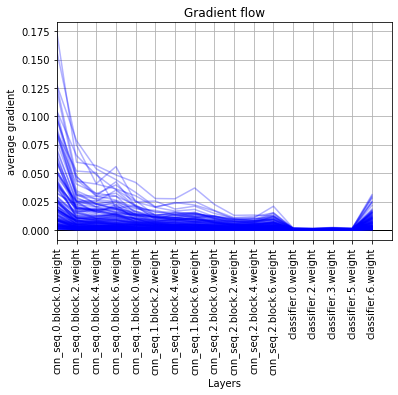

In [219]:
liveloss = PlotLosses(skip_first=0)
for epoch in range(epochs):
    running_loss = 0
    running_correct = 0
    validation_correct = 0
    validation_loss = 0
    cnt = 0
    logs={}
    for i, data in enumerate(trainloader):
        model.train()
        inputs, labels = data
        inputs = inputs.to(device) 
        outputs = model(inputs)
        labels = labels.to(device)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        plot_grad_flow(model.named_parameters())
        optimizer.step()
        running_loss += loss.item()
        running_correct += torch.sum(outputs.argmax(1) == labels).item()
        cnt += len(labels)
        print('\r[%d, %5d] Train_loss: %.3f' %(epoch + 1, i + 1, running_loss/(i+1)),end='')
    logs['loss'] = running_loss/(i+1)
    logs['accuracy'] = running_correct/cnt
    cnt = 0
    for i, data2 in enumerate(validationloader):
        model.eval()
        with torch.no_grad():
            inputs, labels = data2
            inputs = inputs.to(device) 
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            validation_correct += torch.sum(outputs.argmax(1) == labels).item()
            cnt += len(labels)
        
    logs['val_loss'] = validation_loss/(i+1)
    logs['val_accuracy'] = validation_correct/cnt
    liveloss.update(logs)
    liveloss.draw()

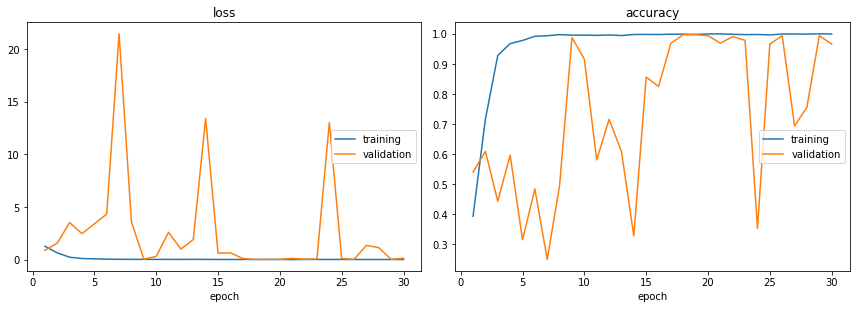

loss:
training   (min:    0.003, max:    1.258, cur:    0.005)
validation (min:    0.009, max:   21.448, cur:    0.123)

accuracy:
training   (min:    0.394, max:    1.000, cur:    0.999)
validation (min:    0.250, max:    0.997, cur:    0.966)


In [62]:
liveloss.draw()

In [210]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

In [ ]:
model(troch.Tensor(traindata[3200][None,None,:,:]))